Epoch 1/10: 100%|██████████| 149/149 [00:12<00:00, 11.99it/s]


Epoch [1/10], Loss: 0.3917, Accuracy: 0.8421


Epoch 2/10: 100%|██████████| 149/149 [00:12<00:00, 11.94it/s]


Epoch [2/10], Loss: 0.2062, Accuracy: 0.9189


Epoch 3/10: 100%|██████████| 149/149 [00:12<00:00, 12.33it/s]


Epoch [3/10], Loss: 0.1453, Accuracy: 0.9449


Epoch 4/10: 100%|██████████| 149/149 [00:12<00:00, 12.18it/s]


Epoch [4/10], Loss: 0.1342, Accuracy: 0.9484


Epoch 5/10: 100%|██████████| 149/149 [00:12<00:00, 12.41it/s]


Epoch [5/10], Loss: 0.1313, Accuracy: 0.9489


Epoch 6/10: 100%|██████████| 149/149 [00:11<00:00, 12.46it/s]


Epoch [6/10], Loss: 0.1283, Accuracy: 0.9500


Epoch 7/10: 100%|██████████| 149/149 [00:12<00:00, 12.34it/s]


Epoch [7/10], Loss: 0.1250, Accuracy: 0.9506


Epoch 8/10: 100%|██████████| 149/149 [00:11<00:00, 12.49it/s]


Epoch [8/10], Loss: 0.1249, Accuracy: 0.9506


Epoch 9/10: 100%|██████████| 149/149 [00:11<00:00, 12.52it/s]


Epoch [9/10], Loss: 0.1224, Accuracy: 0.9515


Epoch 10/10: 100%|██████████| 149/149 [00:12<00:00, 12.40it/s]


Epoch [10/10], Loss: 0.1213, Accuracy: 0.9518


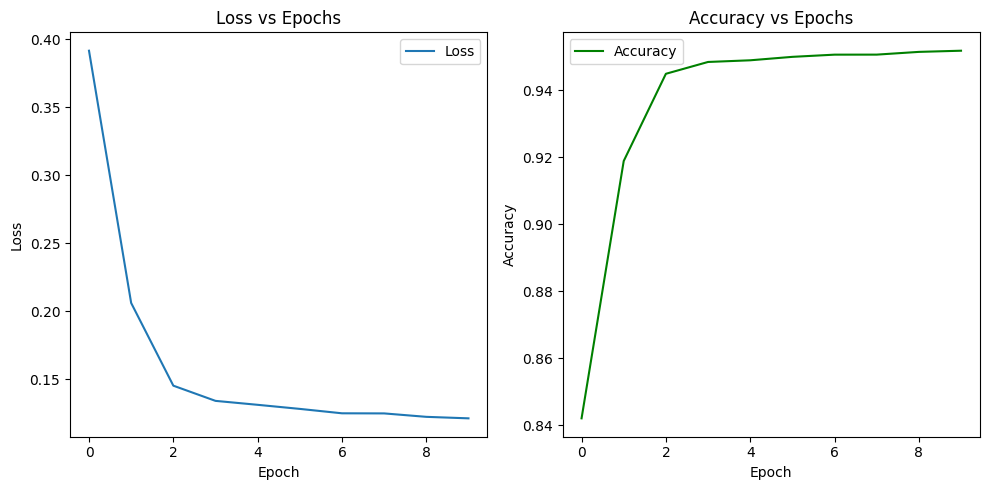

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# UNet网络模型定义（与原始代码保持一致）
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # 编码器部分（Encoder）
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 中间部分（Middle）
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 解码器部分（Decoder）
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),  # 上采样
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)  # 再次上采样
        )
        
        # 最终的1x1卷积层
        self.final_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return self.final_conv(x3)

# 数据集定义（与原始代码保持一致）
class TargetDetectionDataset(Dataset):
    def __init__(self, img_folder, label_folder, transform=None):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform
        self.img_paths = sorted(os.listdir(img_folder))
        self.label_paths = sorted(os.listdir(label_folder))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_paths[idx])
        label_path = os.path.join(self.label_folder, self.label_paths[idx])

        img = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('L')  # 灰度图像
        
        # 统一调整图像和标签的尺寸
        img = img.resize((256, 256))
        label = label.resize((256, 256))
        
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
        
        # 标签二值化处理
        label = (label > 0).float()  # 变为二值标签 (0或1)
        
        return img, label

# 数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 准确率计算函数
def compute_accuracy(outputs, labels):
    # 将输出值转换为0或1
    predicted = (torch.sigmoid(outputs) > 0.5).float()
    correct = (predicted == labels).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

# 训练函数，记录损失和准确率
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    
    # 用于记录损失和准确率
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, labels = imgs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)  # 移除unsqueeze(1)操作
            loss.backward()
            optimizer.step()

            # 计算当前batch的准确率
            accuracy = compute_accuracy(outputs, labels)
            
            running_loss += loss.item()
            running_accuracy += accuracy.item()

        # 计算每个epoch的平均损失和准确率
        epoch_losses.append(running_loss / len(train_loader))
        epoch_accuracies.append(running_accuracy / len(train_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {running_accuracy/len(train_loader):.4f}")

    return epoch_losses, epoch_accuracies

# 数据加载
full_dataset = TargetDetectionDataset(
    img_folder='img',
    label_folder='label',
    transform=transform
)

# 使用torch的random_split划分数据集
train_size = int(0.8 * len(full_dataset))  # 80% 用于训练
val_size = len(full_dataset) - train_size  # 剩下的用于验证
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# 初始化模型
model = UNet(in_channels=3, out_channels=1).cuda()

# 设置损失函数和优化器
criterion = nn.BCEWithLogitsLoss()  # 二分类损失函数
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练模型并记录损失和准确率
epoch_losses, epoch_accuracies = train(model, train_loader, criterion, optimizer, num_epochs=10)

# 绘制loss-epoch曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制accuracy-epoch曲线
plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Accuracy', color='green')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
